In [1]:
!pip install torch==2.1.0 torchtext==0.16.0 transformers datasets portalocker torchvision "numpy>=1.21,<2.0" spacy

# spacy 언어 모델 다운로드
!python -m spacy download de_core_news_sm
!python -m spacy download en_core_web_sm

# !pip install torch transformers portalocker datasets torchtext numpy==2.0 torchtune torchvision
# !pip install torch==2.1.0 transformers portalocker datasets torchtext numpy
# !pip install torch==2.1.0 transformers==4.51.3 portalocker==3.1.1 datasets==3.5.0 torchtext==0.15.1 numpy==1.26.4

  Using cached https://github.com/explosion/spacy-models/releases/download/de_core_news_sm-3.8.0/de_core_news_sm-3.8.0-py3-none-any.whl (14.6 MB)
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
from google.colab import userdata
key = userdata.get('hf-api')

from huggingface_hub import login
login(token=key)

In [3]:
import math, matplotlib.pyplot as plt, os, numpy
import torch, torch.nn as nn
from tqdm import tqdm
from datetime import datetime
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import multi30k, Multi30k
from typing import Iterable, List
from torch import Tensor
from torch.nn import Transformer # https://github.com/pytorch/pytorch/blob/main/torch/nn/modules/transformer.py, https://github.com/pytorch/pytorch/blob/main/torch/nn/modules/activation.py
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from timeit import default_timer as timer

In [4]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {DEVICE}')


Device: cuda


In [5]:
SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'
token_transform = {}
vocab_transform = {}
text_transform = {}

UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3

EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
NUM_EPOCHS = 2 # 5 18 BEST # 50

In [6]:
# current date and time
current_date_time_string = str(datetime.now().strftime("%Y%m%d_%H%M"))

# We need to modify the URLs for the dataset since the links to the original dataset are broken
# Refer to https://github.com/pytorch/text/issues/1756#issuecomment-1163664163 for more info
multi30k.URL["train"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz"
multi30k.URL["valid"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz"


In [8]:
# Place-holders
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')

print(token_transform[SRC_LANGUAGE]("Eine Gruppe von Menschen steht vor einem Iglu ."))
print(token_transform[TGT_LANGUAGE]("A group of people are standing in front of an igloo ."))


['Eine', 'Gruppe', 'von', 'Menschen', 'steht', 'vor', 'einem', 'Iglu', '.']
['A', 'group', 'of', 'people', 'are', 'standing', 'in', 'front', 'of', 'an', 'igloo', '.']


In [9]:
# helper function to yield list of tokens
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
	language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

	for data_sample in data_iter:
		yield token_transform[language](data_sample[language_index[language]])


In [10]:
# Define special symbols and indices. Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
for i, (src, tgt) in enumerate(train_iter):
	if i >= 5:
		break
	print(f"Source[{i}]: {src}")
	print(f"Target[{i}]: {tgt}")

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
	# Create torchtext's Vocab object
	vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
													min_freq=1,
													specials=special_symbols,
													special_first=True)


Source[0]: Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.
Target[0]: Two young, White males are outside near many bushes.
Source[1]: Mehrere Männer mit Schutzhelmen bedienen ein Antriebsradsystem.
Target[1]: Several men in hard hats are operating a giant pulley system.
Source[2]: Ein kleines Mädchen klettert in ein Spielhaus aus Holz.
Target[2]: A little girl climbing into a wooden playhouse.
Source[3]: Ein Mann in einem blauen Hemd steht auf einer Leiter und putzt ein Fenster.
Target[3]: A man in a blue shirt is standing on a ladder cleaning a window.
Source[4]: Zwei Männer stehen am Herd und bereiten Essen zu.
Target[4]: Two men are at the stove preparing food.


/usr/local/lib/python3.11/dist-packages/torch/utils/data/datapipes/iter/combining.py:333: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


In [11]:
# Set ``UNK_IDX`` as the default index. This index is returned when the token is not found.
# If not set, it throws ``RuntimeError`` when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
	vocab_transform[ln].set_default_index(UNK_IDX)
torch.manual_seed(0)



In [12]:
# function to collate data samples into batch tensors
def collate_fn(batch):
	global text_transform

	src_batch, tgt_batch = [], []
	for src_sample, tgt_sample in batch:
		src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
		tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

	src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
	tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
	return src_batch, tgt_batch


In [13]:
# helper function to club together sequential operations
def sequential_transforms(*transforms):
	def func(txt_input):
		for transform in transforms:
			txt_input = transform(txt_input)
		return txt_input
	return func


In [14]:
# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
	return torch.cat((torch.tensor([BOS_IDX]),
					torch.tensor(token_ids),
					torch.tensor([EOS_IDX])))


In [15]:
# hyperparameters
SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])

train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)
val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
	text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
											vocab_transform[ln], #Numericalization
											tensor_transform) # Add BOS/EOS and create tensor


In [16]:
# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
	def __init__(self,
				emb_size: int,
				dropout: float,
				maxlen: int = 5000):
		super(PositionalEncoding, self).__init__()
		den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
		pos = torch.arange(0, maxlen).reshape(maxlen, 1)
		pos_embedding = torch.zeros((maxlen, emb_size))
		pos_embedding[:, 0::2] = torch.sin(pos * den)
		pos_embedding[:, 1::2] = torch.cos(pos * den)
		pos_embedding = pos_embedding.unsqueeze(-2)

		self.dropout = nn.Dropout(dropout)
		self.register_buffer('pos_embedding', pos_embedding)

	def forward(self, token_embedding: Tensor):
		return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])


In [17]:
# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
	def __init__(self, vocab_size: int, emb_size):
		super(TokenEmbedding, self).__init__()
		self.embedding = nn.Embedding(vocab_size, emb_size)
		self.emb_size = emb_size

	def forward(self, tokens: Tensor):
		return self.embedding(tokens.long()) * math.sqrt(self.emb_size)


In [18]:
# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
	def __init__(self,
				num_encoder_layers: int,
				num_decoder_layers: int,
				emb_size: int,
				nhead: int,
				src_vocab_size: int,
				tgt_vocab_size: int,
				dim_feedforward: int = 512,
				dropout: float = 0.1):
		super(Seq2SeqTransformer, self).__init__()
		self.transformer = Transformer(d_model=emb_size,
									nhead=nhead,
									num_encoder_layers=num_encoder_layers,
									num_decoder_layers=num_decoder_layers,
									dim_feedforward=dim_feedforward,
									dropout=dropout)
		self.generator = nn.Linear(emb_size, tgt_vocab_size)
		self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
		self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
		self.positional_encoding = PositionalEncoding(
			emb_size, dropout=dropout)

	def forward(self,
				src: Tensor,
				trg: Tensor,
				src_mask: Tensor,
				tgt_mask: Tensor,
				src_padding_mask: Tensor,
				tgt_padding_mask: Tensor,
				memory_key_padding_mask: Tensor):
		src_emb = self.positional_encoding(self.src_tok_emb(src))
		tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
		outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
								src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
		return self.generator(outs)

	def encode(self, src: Tensor, src_mask: Tensor):
		return self.transformer.encoder(self.positional_encoding(
							self.src_tok_emb(src)), src_mask)

	def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
		return self.transformer.decoder(self.positional_encoding(
						self.tgt_tok_emb(tgt)), memory,
						tgt_mask)


In [19]:
def generate_square_subsequent_mask(sz): # create diagonal matrix
	mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
	mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
	return mask



In [20]:
def create_mask(src, tgt):
	src_seq_len = src.shape[0]
	tgt_seq_len = tgt.shape[0]

	tgt_mask = generate_square_subsequent_mask(tgt_seq_len).to(DEVICE)
	src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool) # don't train future token

	src_padding_mask = (src == PAD_IDX).transpose(0, 1) # padding mask
	tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1) # padding mask
	return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask


In [21]:
def evaluate(val_dataloader, model, loss_fn):
	model.eval()
	losses = 0

	for src, tgt in tqdm(val_dataloader):
		src = src.to(DEVICE)
		tgt = tgt.to(DEVICE)

		tgt_input = tgt[:-1, :]
		src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

		logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

		tgt_out = tgt[1:, :]
		loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
		losses += loss.item()

	return losses / len(list(val_dataloader))


In [22]:
# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol):
	src = src.to(DEVICE)
	src_mask = src_mask.to(DEVICE)

	memory = model.encode(src, src_mask)
	ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
	for i in range(max_len-1):
		memory = memory.to(DEVICE)
		tgt_mask = (generate_square_subsequent_mask(ys.size(0))
					.type(torch.bool)).to(DEVICE)
		out = model.decode(ys, memory, tgt_mask)
		out = out.transpose(0, 1)
		prob = model.generator(out[:, -1])
		_, next_word = torch.max(prob, dim=1)
		next_word = next_word.item()

		ys = torch.cat([ys,
						torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
		if next_word == EOS_IDX:
			break
	return ys


In [23]:
# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
	global text_transform

	model.eval()
	src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1).to(DEVICE)
	num_tokens = src.shape[0]
	src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool).to(DEVICE)
	tgt_tokens = greedy_decode(
		model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
	return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")


In [24]:
def train_epoch(train_dataloader, BATCH_SIZE, model, optimizer, loss_fn):
	model.train()
	losses = 0

	for index, (src, tgt) in tqdm(enumerate(train_dataloader)):
		src = src.to(DEVICE)  # (29,128)
		tgt = tgt.to(DEVICE)  # (36,128)
		tgt_input = tgt[:-1, :]
		src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

		logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)
		optimizer.zero_grad()

		tgt_out = tgt[1:, :] # tgt(sequence, batch)=(36,128). shift sequence left side=(35,128)
		loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1)) # (35*128,voca token prob)=(4480, 10837), tgt_out(4480). loss = max_index of logits's each row is predicted token - tgt_out's each element
		loss.backward()

		optimizer.step()
		losses += loss.item()

	return losses / len(list(train_dataloader))


In [25]:
def train_model():
	global token_tranform, vocab_transform
	global PAD_IDX, BOS_IDX, EOS_IDX, UNK_IDX
	global SRC_VOCAB_SIZE, TGT_VOCAB_SIZE
	global NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE, NHEAD, FFN_HID_DIM

	transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
									NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

	for p in transformer.parameters():
		if p.dim() > 1:
			nn.init.xavier_uniform_(p)

	transformer = transformer.to(DEVICE)
	loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
	optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

	# ``src`` and ``tgt`` language text transforms to convert raw strings into tensors indices
	global text_transform

	# current path of this module
	module_path = "." # os.path.dirname(os.path.abspath(__file__))
	train_losses = []
	val_losses = []
	for epoch in range(1, NUM_EPOCHS+1):
		start_time = timer()
		train_loss = train_epoch(train_dataloader, BATCH_SIZE, transformer, optimizer, loss_fn)
		train_losses.append(train_loss)
		end_time = timer()
		val_loss = evaluate(val_dataloader, transformer, loss_fn)
		val_losses.append(val_loss)

		print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

	model_file = module_path + '/' + current_date_time_string + '_transformer_model.pth'
	torch.save(transformer.state_dict(), model_file)
	print(translate(transformer, "Eine Gruppe von Menschen steht vor einem Iglu ."))

	# plot
	plt.xlabel("Epoch")
	plt.ylabel("Loss")
	plt.legend()
	plt.plot(range(1, NUM_EPOCHS+1), train_losses, label="Train Loss")
	plt.show()

	plt.legend()
	plt.plot(range(1, NUM_EPOCHS+1), val_losses, label="Validation Loss")
	plt.show()

	return model_file


In [26]:
def test_model(model_file):
	global token_tranform, vocab_transform, text_transform
	global PAD_IDX, BOS_IDX, EOS_IDX, UNK_IDX
	global SRC_VOCAB_SIZE, TGT_VOCAB_SIZE
	global NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE, NHEAD, FFN_HID_DIM

	transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
									NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

	# load transformer model
	pth = torch.load(model_file)
	transformer.load_state_dict(pth)
	transformer.eval()
	transformer = transformer.to(DEVICE)

	print(translate(transformer, "Eine Gruppe von Menschen steht vor einem Iglu ."))

	val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
	for i, (src, tgt) in enumerate(val_iter):
		if i >= 5:
			break
		print(f"Source[{i}]: {src}")
		print(f"Target[{i}]: {tgt}")

		output = translate(transformer, src)
		print(f"Predicted[{i}]: {output}")


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/datapipes/iter/combining.py:333: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
227it [00:42,  5.39it/s]
8it [00:00,  9.99it/

Epoch: 1, Train loss: 5.344, Val loss: 4.106, Epoch time = 46.881s


227it [00:41,  5.43it/s]
8it [00:00, 11.57it/s]


Epoch: 2, Train loss: 3.761, Val loss: 3.309, Epoch time = 46.426s
 A group of people are standing in front of a crowd . 


/tmp/ipython-input-25-3507520084.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


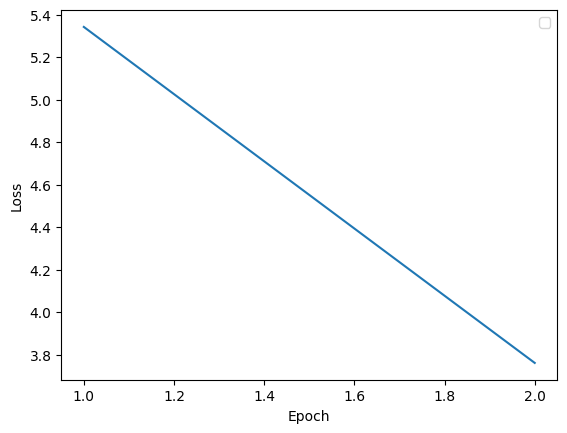

/tmp/ipython-input-25-3507520084.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


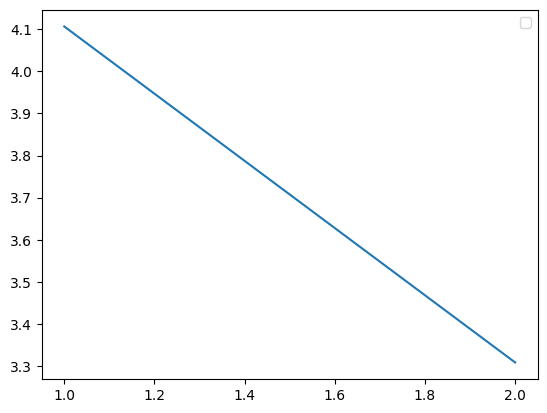

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


 A group of people are standing in front of a crowd . 
Source[0]: Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen
Target[0]: A group of men are loading cotton onto a truck
Predicted[0]:  A group of men are standing on a field . 
Source[1]: Ein Mann schläft in einem grünen Raum auf einem Sofa.
Target[1]: A man sleeping in a green room on a couch.
Predicted[1]:  A man is riding a red shirt on a red shirt . 
Source[2]: Ein Junge mit Kopfhörern sitzt auf den Schultern einer Frau.
Target[2]: A boy wearing headphones sits on a woman's shoulders.
Predicted[2]:  A boy with a black shirt is sitting on a woman . 
Source[3]: Zwei Männer bauen eine blaue Eisfischerhütte auf einem zugefrorenen See auf
Target[3]: Two men setting up a blue ice fishing hut on an iced over lake
Predicted[3]:  Two men are riding a blue shirt on a field . 
Source[4]: Ein Mann mit beginnender Glatze, der eine rote Rettungsweste trägt, sitzt in einem kleinen Boot.
Target[4]: A balding man wearing a red life jack

In [27]:
fname = train_model()
test_model(fname)
# test_model('./20250420_0945_transformer_model.pth')
# test_model('./20250419_2309_transformer_model.pth')